## Install necessary libraries

In [10]:
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 4.2 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install gensim

     |████████████████████████████████| 24.2 MB 4.6 MB/s eta 0:00:01
     |████████████████████████████████| 113 kB 69.4 MB/s eta 0:00:01
  Created wheel for smart-open: filename=smart_open-3.0.0-py3-none-any.whl size=107097 sha256=dbb254361fafb7a0925acfb692d3482c94a6a2786eda065a71bd4e4548125073
  Stored in directory: /home/ec2-user/.cache/pip/wheels/88/2a/d4/f2e9023989d4d4b3574f268657cb6cd23994665a038803f547
Successfully built smart-open
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [123]:
!pip install imbalanced-learn

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


## Import necessary libraries

In [3]:
import numpy as np
import pandas as pd
import boto3
import tensorflow as tf
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.client import device_lib
from keras.constraints import maxnorm
from keras.layers import Dropout
import time
import warnings

#from keras.preprocessing import sequence

Using TensorFlow backend.


In [2]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17037567901941032771,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10537375238087818236
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13540715296108806658
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11338085172
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10512267807107589793
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"]

## Read tidy data into pandas dataframe

In [4]:
# Read the tidy (lemmatized) data into pandas dataframe
client = boto3.client('s3')
path = 's3://bauka-big-tweets/lemmatized.json'
df= pd.read_json(path, orient='table')

## Tag the tweets with labels (positive/negative)

In [7]:
df.head()

,text,lemmatized,tokens_back_to_text
0,"[rudygiuliani, competing, town, halls, joke, s...","[rudygiuliani, compete, town, hall, joke, step...",rudygiuliani compete town hall joke stephanopo...
1,"[trump, machismo]","[trump, machismo]",trump machismo
2,"[briantylercohen, biden, like, encyclopedia, t...","[briantylercohen, biden, like, encyclopedia, t...",briantylercohen biden like encyclopedia tonigh...
3,"[bradleywhitford, yo, semites, qanon, hate, de...","[bradleywhitford, yo, semite, qanon, hate, dem...",bradleywhitford yo semite qanon hate democrat ...
4,"[actbrigitte, president, trump, debate]","[actbrigitte, president, trump, debate]",actbrigitte president trump debate


In [8]:
tweets = list(df['tokens_back_to_text'])
type(tweets)

list

In [9]:
len(tweets)

407766

In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
sid = SentimentIntensityAnalyzer()
sentiment = [sid.polarity_scores(tweet) for tweet in tweets]
len(sentiment)

407766

In [13]:
sentiments = pd.DataFrame(sentiment, index = df.index)
sentiments.shape

(407766, 4)

In [113]:
sentiments.head()

,neg,neu,pos,compound
0,0.000,0.722,0.278,0.5000
1,0.000,1.000,0.000,0.0000
2,0.000,0.667,0.333,0.5423
3,0.552,0.448,0.000,-0.9022
4,0.000,1.000,0.000,0.0000


In [114]:
sentiments.isnull().sum()

neg         0
neu         0
pos         0
compound    0
dtype: int64

In [115]:
compound = sentiments[['compound']].values

In [116]:
# Tag the tweets with labels using k-means clustering algorithm
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(compound)
labels = pd.DataFrame(kmeans.labels_, columns=['label'], index=df.index)
labels.head()

,label
0,1
1,1
2,1
3,0
4,1


In [117]:
labels['label'].value_counts()

1    280321
0    127445
Name: label, dtype: int64

## Feature extraction

In [118]:
# prepare tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)

In [119]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 65125 unique tokens.


In [120]:
# integer encode the documents
sequences = tokenizer.texts_to_sequences(tweets)

In [121]:
# pad documents to a max length of 14 words
maxlen = 14
X = pad_sequences(sequences, maxlen=maxlen)

In [122]:
X.shape

(407766, 14)

## SMOTE - balance the imbalanced dataset

In [125]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# define pipeline
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, labels['label'])

In [126]:
from collections import Counter
counter = Counter(y)
print(counter)

Counter({1: 175200, 0: 140160})


In [127]:
# One-hot encoding of labels
from keras.utils.np_utils import to_categorical
y = to_categorical(y)

## Split the dataset into training and test sets

In [130]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [131]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((220752, 14), (94608, 14), (220752, 2), (94608, 2))

## Modeling - Simple RNN and LSTM

In [132]:
# Prepare hyperparameters of RNN
vocab_size = len(word_index)+1
output_dim = 32

In [133]:
# SimpleRNN
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(SimpleRNN(output_dim=output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim=output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim=output_dim))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
warnings.filterwarnings("ignore")

In [134]:
start = time.time()

# Fit the model to the training set
rnn_hist = model.fit(X_train, y_train, epochs=3, validation_split=0.6)
# Final evaluation of the model
warnings.filterwarnings("ignore")
scores = model.evaluate(X_test, y_test, verbose=0)
warnings.filterwarnings("ignore")
print("Accuracy: %.2f%%" % (scores[1]*100))

end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Train on 88300 samples, validate on 132452 samples
Epoch 1/3
88300/88300 [==============================] - 163s 2ms/step - loss: 0.2284 - acc: 0.9045 - val_loss: 0.1578 - val_acc: 0.9468
Epoch 2/3
88300/88300 [==============================] - 158s 2ms/step - loss: 0.1261 - acc: 0.9556 - val_loss: 0.1525 - val_acc: 0.9463
Epoch 3/3
88300/88300 [==============================] - 160s 2ms/step - loss: 0.1153 - acc: 0.9592 - val_loss: 0.1522 - val_acc: 0.9474
Accuracy: 94.87%
Training duration(minutes): 8.809316988786062


In [135]:
# LSTM
warnings.filterwarnings("ignore")
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(LSTM(output_dim=output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim=output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim=output_dim, kernel_constraint=maxnorm(3)))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [142]:
# Save the LSTM model
model.save('lstm.h5')

In [136]:
start = time.time()

# Fit the model to the training set
warnings.filterwarnings("ignore")
lstm_hist = model.fit(X_train, y_train, epochs=3, validation_split=0.3)
# Final evaluation of the model
warnings.filterwarnings("ignore")
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Train on 154526 samples, validate on 66226 samples
Epoch 1/3
154526/154526 [==============================] - 457s 3ms/step - loss: 0.1978 - acc: 0.9260 - val_loss: 0.1576 - val_acc: 0.9439
Epoch 2/3
154526/154526 [==============================] - 446s 3ms/step - loss: 0.1426 - acc: 0.9511 - val_loss: 0.1441 - val_acc: 0.9506
Epoch 3/3
154526/154526 [==============================] - 448s 3ms/step - loss: 0.1348 - acc: 0.9532 - val_loss: 0.1399 - val_acc: 0.9506
Accuracy: 95.26%
Training duration(minutes): 23.97068918943405


In [137]:
!nvidia-smi

Tue Nov 10 00:00:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   53C    P0    71W / 149W |  10963MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Model Evaluation

### SimpleRNN Result

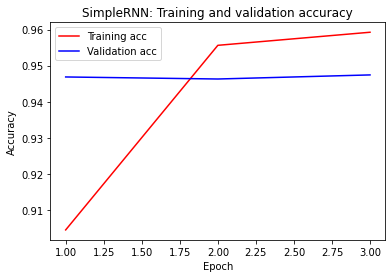

In [138]:
import matplotlib.pyplot as plt
acc = rnn_hist.history['acc']
val_acc = rnn_hist.history['val_acc']
loss = rnn_hist.history['loss']
val_loss = rnn_hist.history['val_loss']
epochs = range(1, len(acc)+1)
_ = plt.plot(epochs, acc, 'r', label='Training acc')
_ = plt.plot(epochs, val_acc, 'b', label='Validation acc')
_ = plt.title('SimpleRNN: Training and validation accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend(loc='best')
plt.show()

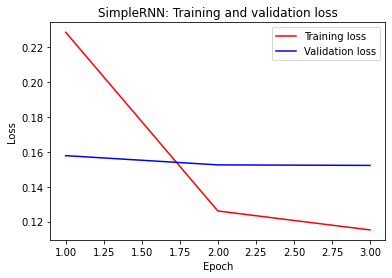

In [139]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('SimpleRNN: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()

### LSTM Result

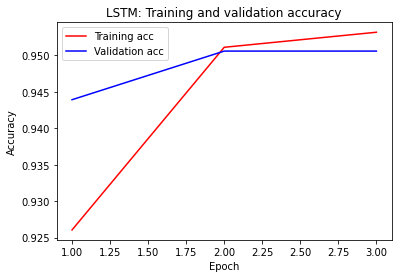

In [140]:
acc = lstm_hist.history['acc']
val_acc = lstm_hist.history['val_acc']
loss = lstm_hist.history['loss']
val_loss = lstm_hist.history['val_loss']
epochs = range(1, len(acc)+1)
_ = plt.plot(epochs, acc, 'r', label='Training acc')
_ = plt.plot(epochs, val_acc, 'b', label='Validation acc')
_ = plt.title('LSTM: Training and validation accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend(loc='best')
plt.show()

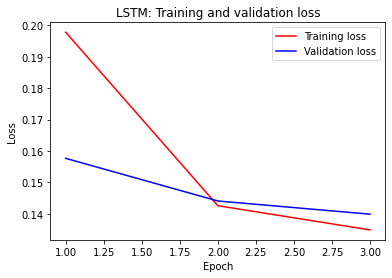

In [141]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('LSTM: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()

## Predict with the LSTM model

In [143]:
from keras.models import load_model
lstm = load_model('lstm.h5')

In [145]:
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 14, 32)            2084032   
_________________________________________________________________
lstm_10 (LSTM)               (None, 14, 32)            8320      
_________________________________________________________________
dropout_38 (Dropout)         (None, 14, 32)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 14, 32)            8320      
_________________________________________________________________
dropout_39 (Dropout)         (None, 14, 32)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 66        
Total para

In [146]:
predictions = lstm.predict(X_test)

In [147]:
probability_true = predictions[:,1]

In [148]:
len(probability_true)

94608

In [149]:
probability_true

array([0.00303076, 0.19198489, 0.99407107, ..., 0.99186265, 0.99106544,
       0.00682921], dtype=float32)

## Conclusion

In this project, I attempted predict the sentiments of the tweets related to the 2020 US election. To do that, I collected my own dataset by scraping the tweets via Twitter API and Tweepy package in Python. Over 440,000 tweets were streamed via Twitter API and stored into a CSV file. After wrangling and visualizing the data, PySpark on Amazon EMR cluster was used to take advantage of the distributed computing to preprocess the dataset. After the tweets have been labeled into 2 classes (positive/negative), the dataset was split into training and test sets. K-Means clustering algorithm was used to label the dataset into 2 clusters. Later, the training set was used to train SimpleRNN and LSTM models respectively and were evlauated using the loss and accuracy of the models in each epoch on the test set. Overall, both models appear to be performing well but they might be overfitting the data as well because of the accuracies from both models came out to be around 95%. 

Recommended next steps:

- Find another approach or different clustering algorithms to label the dataset
- Try Amazon sagemaker labeling algorithms to label the dataset
- Try different RNN architectures 
- Perform more advanced tuning of the hyperparameters of the RNN architectures
- Perform cross-validation
- Make the data multi-class problem 

## Skills practiced during this project 
1. How to efficiently collect data from Tweeter via Tweepy and Tweeter  API
2. How to work with big data:

        a. How to export data to JSON and read from JSON
    
        b. How to efficiently read and clean unstructured large text data
    
        c. How to set up and use PySpark on Amazon EMR
    
        d. How to set up and use AWS EC2 instance with Deep Learning AMI
    
        e. How to train deep learning model using Amazon Sagemaker GPU instance
    
    
3. How to build Deep learning (RNN, LSTM) architecture, compile and fit model with Keras
4. How to apply NLP concepts and techniques to text data